In [1]:
import numpy as np

# Find indices of the different peaks in the data
def findPeakIndices(data):
    n = int(round(sum(data[:,1] == 0)/2)+1)
    indices = np.zeros([n,2], dtype="uint32")
    a = False
    ii = 0
    for i in range(len(data[:,1])-1):
        if data[i,1] == 0 and a:
            indices[ii, 1] = i - 1
            if ii != n:
                indices[ii+1, 0] = i
            ii += 1
        a = data[i,1] == 0
    last = n-sum(indices[:,0]>=indices[:,1])
    indices = indices[0:last+1,:]
    indices[last, 1] = len(data[:,0]) - 1
    return indices

In [2]:
from scipy.optimize import leastsq
import numpy as np

# Get one mean by fitting a Gaussian distribution to the data
# with resolution of 280000
def getMean(peak):
    mu = np.average(peak[:,0], weights=peak[:,1])
    sigma = mu/(280000*2*np.sqrt(2*np.log(2)))
    fitfunc  = lambda p, x: p[0]*np.exp(-0.5*((x-p[1])/sigma)**2)
    errfunc  = lambda p, x, y: (y - fitfunc(p, x))
    init  = [1.0, mu]
    out = leastsq(errfunc, init, args=(peak[:,0], peak[:,1]))
    c = out[0]
    return c

In [3]:
from scipy.optimize import minimize
import numpy as np
import scipy.signal as scs

# Calculate mean square error for the model
def MSE(x, y, a, mu, sigma):
    norm = lambda a, mu, x: a*np.exp(-0.5*((x-mu)/sigma)**2)
    error = 0
    for i in range(len(y)):
        error = error + (y[i] - np.sum(norm(a,mu,x[i])))**2
    return error/len(y)

def errorFunction(x, y, sigma):
    return lambda params: MSE(x, y, params[::2], params[1::2], sigma)

# Function used to group values that are too close (abs(mu[n]-mu[n+1])<th) to each other together
def group(mu, th):
    groups = []
    unassigned = np.linspace(0,len(mu)-1,len(mu)).astype(int)
    while len(unassigned) > 0:
        dist = abs(np.array(mu[unassigned]) - mu[unassigned[0]])
        group = unassigned[dist < th]
        unassigned = unassigned[dist >= th]
        groups += [group]
    return groups



# Get one or more means depending on if there are multiple peaks in the data
# by fitting one or more Gaussian distributions to the data using resolution of 280000 
def getMeans(peaks):
    ind = scs.find_peaks(peaks[:,1], max(peaks[:,1])/20, prominence=max(peaks[:,1])/10)[0]
    mu = peaks[ind,0]
    n = len(mu)
    sigma = mu/(280000*2*np.sqrt(2*np.log(2)))
    
    init  = []
    for i in range(len(mu)):
        init += [np.mean(peaks[:,1]), mu[i]]
    
    # Fit n Gaussian distributions to the data
    f = errorFunction(peaks[:,0], peaks[:,1], sigma)
    params = minimize(f, init, method='BFGS').x
    
    a = params[::2]
    mu = params[1::2]
    
    # Group fitted distributions that are too close to each other together
    # and combine them
    groups = group(mu, 1e-5)
    a2 = np.zeros(len(groups))
    mu2 = np.zeros(len(groups))
    sigma2 = np.zeros(len(groups))
    for i in range(len(groups)):
        mu2[i] = np.mean(mu[groups[i]])
        a2[i] = np.sum(a[groups[i]])
        sigma2[i] = np.mean(sigma[groups[i]])
    return mu2, a2, sigma2

In [4]:
import numpy as np

# Get all peak means for the data
def getAllMeans(peaks):
    indices = findPeakIndices(peaks)
    n = len(indices[:,0])
    means = []
    aa = []
    sigmas = []
    peaki = []
    for i in range(n):
        peak = peaks[indices[i,0]:indices[i,1]+1,:]
        mu, a, sigma = getMeans(peak)
        for ii in range(len(a)):
            means += [mu[ii]]
            aa += [a[ii]]
            sigmas += [sigma[ii]]
            peaki += [i]
    return means, aa, sigmas, peaki

In [5]:
import pandas as pd
import numpy as np

# Identify peaks and return a data frame of peaks and their properties
def identifyPeaks(data, peaklist, th):
    peaklist['observed'] = np.zeros(len(peaklist['mz']))
    peaklist['a'] = np.zeros(len(peaklist['mz']))
    peaklist['sigma'] = np.zeros(len(peaklist['mz']))
    peaklist['peak'] = np.zeros(len(peaklist['mz']))
    peakMeans, a, sigmas, ind = getAllMeans(data)
    trueValue = peaklist['mz'].to_numpy()
    for i in range(len(trueValue)):
        if min(abs(peakMeans - trueValue[i])) < th:
            j = np.argmin(abs(peakMeans - trueValue[i]))
            peaklist.iloc[i,2] = peakMeans[j]
            peaklist.iloc[i,3] = a[j]
            peaklist.iloc[i,4] = sigmas[j]
            peaklist.iloc[i,5] = ind[j]
    unidentified = np.linspace(0, len(trueValue)-1, len(trueValue))
    unidentified = unidentified[peaklist['observed'].to_numpy() == 0]
    return peaklist.drop(unidentified)

In [6]:
# Calculate intensity from a and sigma values that you can find from the identifyPeaks() data  frame
def getIntensity(a, sigma):
    return a/sigma*np.sqrt(2*np.pi)

# Calculate logarithm of intensity from a and sigma values that you can find from the identifyPeaks() data  frame
def getLogIntensity(a, sigma):
    return np.log(a) - np.log(sigma) + 0.5*np.log(2*np.pi)

In [7]:
import numpy as np
import pandas as pd

# Read a file in the correct format for these functions
def readFile(fileName):
    return pd.read_csv(fileName).iloc[3:,:2].to_numpy().astype("float64")

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

plt.rcParams['figure.figsize'] = [12, 10]

# Plot a peak i from a peaklist that's fram data
def plotPeak(i, peaklist, data):
    if i < len(peaklist.iloc[:,0]):
        peakindex = findPeakIndices(data)
        ii = int(peaklist.iloc[i,5])
        peak = data[peakindex[ii,0]:peakindex[ii,1]+1]
        plt.plot(peak[:,0],peak[:,1])
        middle = round(len(peak[:,0])/2)
        x = np.linspace(peak[0,0],peak[-1,0],1000)
        y = peaklist.iloc[i,3]*np.exp(-0.5*((x-peaklist.iloc[i,2])/peaklist.iloc[i,4])**2)
        plt.plot(x,y)
        plt.vlines(peaklist.iloc[i,2],0,max(peak[:,1]))
        plt.vlines(peaklist.iloc[i,1],0,max(peak[:,1]), color = "green")
        plt.legend(["Data","Fitted normal distribution","Mean from data","True mean"])
        plt.title(peaklist.iloc[i,0])
        plt.show()

In [9]:
# Choose n peaks with the smallest error
def selectPeaksMinimumError(peaks, n):
    errors = abs(peaks.iloc[:,1]-peaks.iloc[:,2])
    ind = np.argpartition(errors, n)
    return peaks.iloc[ind[:n],:], peaks.iloc[ind[n:],:]

# Choose n peaks with error closest to the mean error
def selectPeaksMeanError(peaks, n):
    errors = abs(peaks.iloc[:,1]-peaks.iloc[:,2])
    ind = np.argpartition(abs(errors-np.mean(errors)), n)
    return peaks.iloc[ind[:n],:], peaks.iloc[ind[n:],:]

# Choose n peaks with error closest to the median error
def selectPeaksMedianError(peaks, n):
    errors = abs(peaks.iloc[:,1]-peaks.iloc[:,2])
    ind = np.argpartition(abs(errors-np.median(errors)), n)
    return peaks.iloc[ind[:n],:], peaks.iloc[ind[n:],:]

# Splits the peaks into k partitions and selects n peaks from each partition
# so it results in n*k peaks for training and the rest of the peaks for testing
def selectPeaks(peaklist, n, k, select=selectPeaksMinimumError):
    n_peaks = len(peaklist.iloc[:,0])
    partition_size = int((n_peaks - (n_peaks % k)) / k)
    test = pd.DataFrame(columns=["formula","mz","observed","a","sigma","peak"])
    train = pd.DataFrame(columns=["formula","mz","observed","a","sigma","peak"])
    for i in range(k):
        if i < k-1:
            partition = peaklist.iloc[i*partition_size:(i+1)*partition_size,:]
        else:
            partition = peaklist.iloc[i*partition_size:,:]
        tr, ts = select(partition, n)
        test = test.append(ts)
        train = train.append(tr)
    return train, test

In [10]:
def combineObservations(peaklists):
    peaklist = peaklists[0][["formula", "mz", "observed"]].set_index("formula")
    for i in range(len(peaklists)-1):
        peaklist = peaklist.join(peaklists[i+1][["formula", "observed"]].set_index("formula"), on="formula", rsuffix='_'+str(i+1))
    return peaklist

def combinePeaklists(peaklists):
    peaklist = peaklists[0].set_index("formula")
    for i in range(len(peaklists)-1):
        peaklist = peaklist.join(peaklists[i+1].drop("mz", axis=1).set_index("formula"), on="formula", rsuffix='_'+str(i+1))
    return peaklist

In [11]:
# example

import numpy as np
import pandas as pd

files = ["data/N_minutes_60_N_spectra_10/spectrum_2020-00-17_17_11_07.csv",
         "data/N_minutes_60_N_spectra_10/spectrum_2020-00-17_17_11_18.csv",
         "data/N_minutes_60_N_spectra_10/spectrum_2020-00-17_21_11_31.csv"]

data1 = readFile(files[0])
data2 = readFile(files[1])
data3 = readFile(files[2])

data = readFile("data/N_minutes_60_N_spectra_10/spectrum_2020-00-17_21_11_31.csv")

In [12]:
import pandas as pd
import numpy as np

peaklist = identifyPeaks(data1, pd.read_csv("peaklist.csv"), 1e-4)
peaklist2 = identifyPeaks(data2, pd.read_csv("peaklist.csv"), 1e-4)
peaklist3 = identifyPeaks(data3, pd.read_csv("peaklist.csv"), 1e-4)

print(peaklist)

            formula          mz    observed             a     sigma   peak
2              O3N-   61.988366   61.988374  2.507348e+06  0.000094    5.0
3          O3N[15]-   62.985401   62.985426  8.328423e+03  0.000096   10.0
4         O2O[17]N-   62.992584   62.992602  2.644745e+03  0.000096   11.0
5         O2O[18]N-   63.992613   63.992623  1.577415e+04  0.000097   12.0
10           C2HO4-   88.988032   88.988120  2.605163e+03  0.000135   15.0
16          C3H3O4-  103.003682  103.003768  8.110238e+03  0.000156   16.0
21          C2O2F3-  112.985587  112.985649  7.397827e+02  0.000171   18.0
26          C4H5O4-  117.019332  117.019400  1.934514e+03  0.000177   19.0
29          CH2O6N-  123.988760  123.988718  7.014656e+02  0.000188   20.0
30           HO6N2-  124.984009  124.984002  1.152064e+06  0.000190   22.0
32       HO6NN[15]-  125.981044  125.981036  7.785423e+03  0.000191   26.0
33      HO5O[17]N2-  125.988226  125.988225  1.443392e+03  0.000191   27.0
34      HO5O[18]N2-  126.

In [13]:
peaklists = [peaklist, peaklist2, peaklist3]
combineObservations(peaklists)

,mz,observed,observed_1,observed_2
formula,,,,
O3N-,61.988366,61.988374,61.988375,61.988376
O3N[15]-,62.985401,62.985426,62.985426,62.985425
O2O[17]N-,62.992584,62.992602,62.992598,62.992600
O2O[18]N-,63.992613,63.992623,63.992625,63.992623
C2HO4-,88.988032,88.988120,88.988109,88.988120
C3H3O4-,103.003682,103.003768,103.003761,103.003767
C2O2F3-,112.985587,112.985649,112.985675,NaN
C4H5O4-,117.019332,117.019400,117.019377,117.019398
CH2O6N-,123.988760,123.988718,123.988746,123.988731


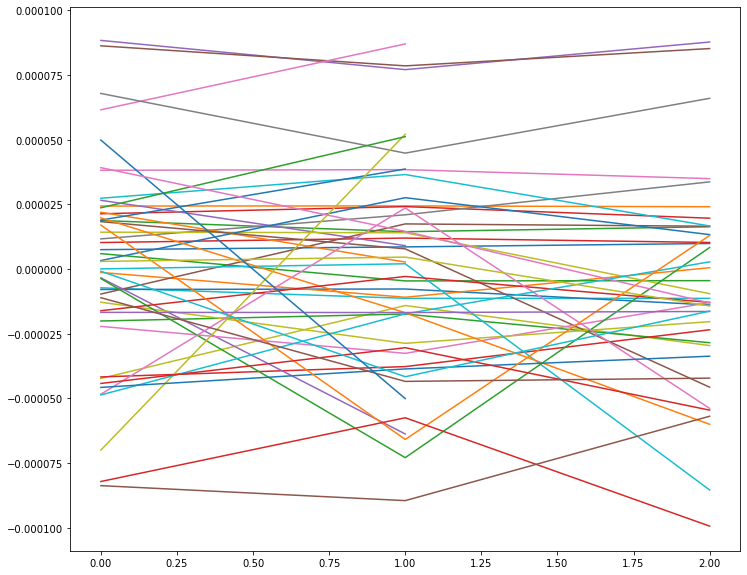

In [14]:
lists = peaklist.set_index("formula").join(peaklist2.set_index("formula"), on="formula", rsuffix='_2').join(peaklist3.set_index("formula"), on="formula", rsuffix='_3')
plt.plot(range(3), [lists["observed"]-lists["mz"], lists["observed_2"]-lists["mz"], lists["observed_3"]-lists["mz"]])
plt.show()

In [15]:
print(getLogIntensity(peaklist.iloc[0,3], peaklist.iloc[0,4]))
print(getIntensity(peaklist.iloc[0,3], peaklist.iloc[0,4]))

24.925737038087547
66851330167.3378


In [16]:
ind = findPeakIndices(data)
i = 88
peak = data[ind[i,0]:ind[i,1]+1,:]
getMeans(peak)

(array([294.04635112]), array([551.2360825]), array([0.00044596]))

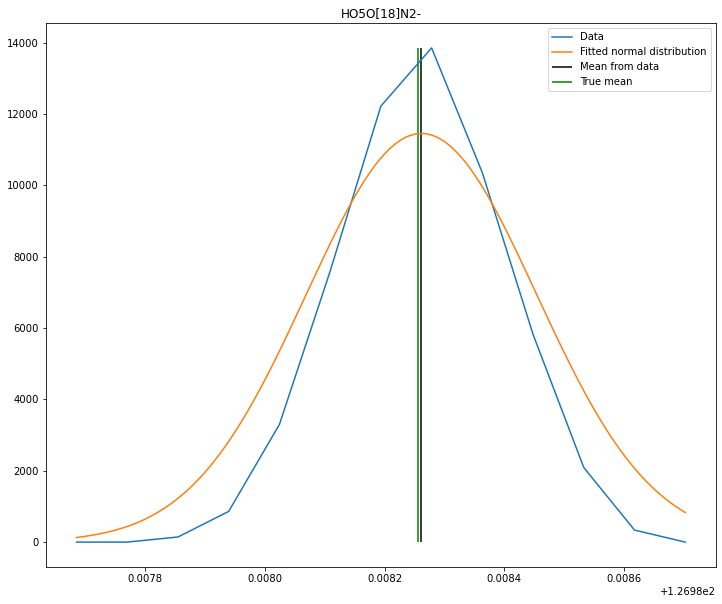

In [17]:
# Plot a peak
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

i = 12
plotPeak(i, peaklist, data1)

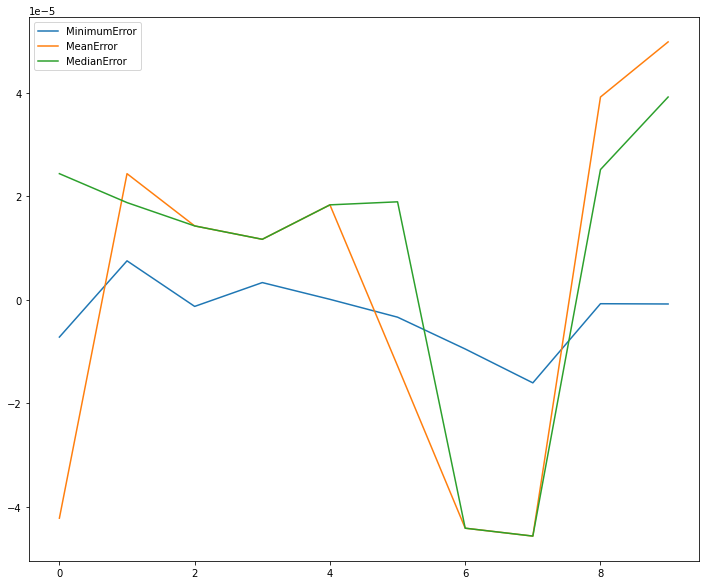

In [18]:
n = 2
k = 5

y = selectPeaks(peaklist, n, k, selectPeaksMinimumError)[0]
y = y.iloc[:,2] - y.iloc[:,1]
y2 = selectPeaks(peaklist, n, k, selectPeaksMeanError)[0]
y2 = y2.iloc[:,2] - y2.iloc[:,1]
y3 = selectPeaks(peaklist, n, k, selectPeaksMedianError)[0]
y3 = y3.iloc[:,2] - y3.iloc[:,1]
plt.plot(range(len(y)), y)
plt.plot(range(len(y2)), y2)
plt.plot(range(len(y3)), y3)
plt.legend(["MinimumError", "MeanError", "MedianError"])
plt.show()